In [14]:
# Import utility functions
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import requests
import json
sys.path.append('..')  # Add parent directory to path

# Import from local utility modules
from lvt_utils import (model_split_rate_tax, calculate_current_tax, ensure_geodataframe, 
                       categorize_property_type, calculate_category_tax_summary, print_category_tax_summary)
from census_utils import (get_census_data_with_boundaries, match_parcels_to_demographics, 
                          create_demographic_summary, calculate_median_percentage_by_quintile, match_to_census_blockgroups)
from viz import (create_scatter_plot, plot_comparison, calculate_correlations, weighted_median, 
                 create_quintile_summary, plot_quintile_analysis, create_property_category_chart, 
                 create_map_visualization, calculate_block_group_summary, filter_data_for_analysis)

# Control variable for data scraping
data_scrape = 1  # Set to 1 to scrape new data, 0 to use existing data

print("✅ Utility functions imported from LVTShift modules")


✅ Utility functions imported from LVTShift modules


In [15]:
import glob
from datetime import datetime

# Data directories
data_dir = "data/rochester/"
os.makedirs(data_dir, exist_ok=True)

# --- URLs for Rochester Open Data (ArcGIS REST) ---
PARCELS_URL = "https://maps.cityofrochester.gov/arcgis/rest/services/App_PropertyInformation/ROC_Parcel_Query_RPS_Merged/MapServer/0/query"
EXEMPTIONS_URL = "https://maps.cityofrochester.gov/arcgis/rest/services/App_PropertyInformation/ROC_Parcel_Query_RPS_Merged/MapServer/8/query"
TAXBILL_URL = "https://maps.cityofrochester.gov/arcgis/rest/services/App_PropertyInformation/ROC_Parcel_Query_RPS_Merged/MapServer/9/query"

def download_arcgis_layer(url, id_col=None, geo=True, max_records=10000):
    """
    Download an entire ArcGIS REST layer (table or geojson) in batches.
    """
    import pandas as pd
    import geopandas as gpd

    # First grab record count
    r = requests.get(url, params={"where":"1=1","returnCountOnly":"true","f":"json"})
    n_records = r.json()["count"]

    dfs = []
    for start in range(0, n_records, max_records):
        params = {
            "where": "1=1",
            "outFields": "*",
            "f": "geojson" if geo else "json",
            "resultOffset": start,
            "resultRecordCount": min(max_records, n_records - start),
            "returnGeometry": str(geo).lower()
        }
        resp = requests.get(url, params=params)
        if geo:
            gdf = gpd.GeoDataFrame.from_features(resp.json()["features"])
        else:
            records = resp.json()["features"] if "features" in resp.json() else []
            # ArcGIS tables return JSON with features > attributes
            attr = [rec["attributes"] for rec in records]
            gdf = pd.DataFrame(attr)
        dfs.append(gdf)
        print(f"Downloaded {(start+1)}–{start+params['resultRecordCount']} of {n_records}", end="\r")
    df = pd.concat(dfs, ignore_index=True)
    return df

if data_scrape == 1:
    print("🔄 Downloading fresh Rochester property data...")

    # Download parcels (GeoDataFrame)
    print("📥 Downloading parcels...")
    gdf = download_arcgis_layer(PARCELS_URL, geo=True)
    print(f"✅ Downloaded {len(gdf):,} Rochester parcels")

    # Download exemptions (DataFrame, join by SBL20 to PARCELID)
    print("📥 Downloading exemptions...")
    exemptions = download_arcgis_layer(EXEMPTIONS_URL, geo=False)
    # Clean and sum multiple records for the same SBL (if present)
    exemptions["ExemptionAmount"] = pd.to_numeric(exemptions["ExemptionAmount"], errors="coerce").fillna(0)
    exemptions_sum = exemptions.groupby("SBL20")["ExemptionAmount"].sum().reset_index()
    exemptions_sum.rename(columns={"ExemptionAmount":"total_exemptions"}, inplace=True)

    # Download tax bill info (DataFrame, join by SBL20 to PARCELID)
    print("📥 Downloading tax bill data...")
    taxbill = download_arcgis_layer(TAXBILL_URL, geo=False)
    # Take the most recent tax bill per parcel if multiple
    taxbill_latest = taxbill.sort_values(["SBL20", "YR_2023"], ascending=[True,False])
    taxbill_latest = taxbill_latest.groupby("SBL20").first().reset_index() # Only most recent bill per parcel

    # Join the auxiliary data to main parcels
    gdf = gdf.merge(exemptions_sum, left_on="PARCELID", right_on="SBL20", how="left")
    gdf = gdf.merge(taxbill_latest, left_on="PARCELID", right_on="SBL20", how="left", suffixes=("", "_bill"))
    gdf["total_exemptions"] = gdf["total_exemptions"].fillna(0)

    # Calculate land/improvement and property tax variables based on Rochester column names
    gdf["land_value"] = gdf["CURRENT_LAND_VALUE"]
    gdf["total_value"] = gdf["CURRENT_TOTAL_VALUE"]
    gdf["taxable_value"] = gdf["CURRENT_TAXABLE_VALUE"]

    # If available, use TrueTax from bill. Otherwise, estimate using mill rate
    # Using city's stated mill rate in 2023: 20.992 per $1000 (source: https://www.cityofrochester.gov/article.aspx?id=8589935801)
    # But we use observed tax first
    gdf["property_tax"] = gdf["TrueTax"]
    missing_tax = gdf["property_tax"].isna()
    gdf.loc[missing_tax, "property_tax"] = gdf.loc[missing_tax, "taxable_value"] * (19.74/1000)

    # Compute improvement value, basic split-rate logic (if you wish)
    gdf["improvement_value"] = gdf["total_value"] - gdf["land_value"]

    # Save parquet
    today_str = datetime.now().strftime("%Y%m%d")
    save_path = f"{data_dir}rochester_parcels_processed_{today_str}.parquet"
    gdf.to_parquet(save_path)
    print(f"💾 Saved processed data to {save_path}")

else:
    print("📂 Loading existing Rochester property data...")
    # Find all processed parquet files in the data_dir
    parquet_files = glob.glob(os.path.join(data_dir, "rochester_parcels_processed_*.parquet"))
    if not parquet_files:
        print("❌ No processed Rochester data files found in data/rochester/. Please set data_scrape = 1 to download fresh data.")
        raise FileNotFoundError("No processed Rochester data files found.")
    # Extract dates and find the most recent file
    def extract_date(f):
        try:
            return datetime.strptime(os.path.basename(f).split("_")[-1].replace(".parquet", ""), "%Y%m%d")
        except Exception:
            return datetime.min
    parquet_files_sorted = sorted(parquet_files, key=extract_date, reverse=True)
    most_recent_file = parquet_files_sorted[0]
    gdf = gpd.read_parquet(most_recent_file)
    print(f"✅ Loaded processed Rochester data from {most_recent_file}")

print(f"\n📊 Dataset Overview:")
print(f"Total parcels: {len(gdf):,}")
print(f"Columns: {len(gdf.columns)}")
if isinstance(gdf, gpd.GeoDataFrame):
    print(f"Geometry type: {gdf.geometry.geom_type.iloc[0]}")

# Display key statistics
total_current_revenue = gdf['property_tax'].sum()
print(f"\n💰 Current Tax System:")
print(f"Total annual revenue: ${total_current_revenue:,.2f}")
print(f"Mean property tax: ${gdf['property_tax'].mean():,.2f}")
print(f"Median property tax: ${gdf['property_tax'].median():.2f}")


🔄 Downloading fresh Rochester property data...
📥 Downloading parcels...
✅ Downloaded 64,762 Rochester parcels
📥 Downloading exemptions...
📥 Downloading tax bill data...
💾 Saved processed data to data/rochester/rochester_parcels_processed_20251105.parquet

📊 Dataset Overview:
Total parcels: 64,762
Columns: 89
Geometry type: Polygon

💰 Current Tax System:
Total annual revenue: $301,912,439.34
Mean property tax: $4,665.41
Median property tax: $2206.84


In [16]:
# Compare TrueTax to property_tax and the percent of times they are equal

# Both columns should exist, but handle missing TrueTax gracefully
if 'TrueTax' in gdf.columns and 'property_tax' in gdf.columns:
    # Compare values (allow for floating-point error, e.g., tolerance 0.01)
    tol = 0.01
    valid = gdf['TrueTax'].notna() & gdf['property_tax'].notna()
    # Absolute difference less than tol means "equal"
    equal_mask = (abs(gdf.loc[valid, 'TrueTax'] - gdf.loc[valid, 'property_tax']) < tol)
    percent_equal = 100 * equal_mask.sum() / valid.sum() if valid.sum() > 0 else float('nan')
    print(f"\n🔎 TrueTax vs property_tax comparison:")
    print(f"Number of parcels compared: {valid.sum():,}")
    print(f"Number of exact matches (within ${tol}): {equal_mask.sum():,}")
    print(f"Percent of parcels where TrueTax == property_tax: {percent_equal:.2f}%")
else:
    print("One or both columns ('TrueTax', 'property_tax') are missing from the GeoDataFrame.")




🔎 TrueTax vs property_tax comparison:
Number of parcels compared: 61,358
Number of exact matches (within $0.01): 61,358
Percent of parcels where TrueTax == property_tax: 100.00%


In [17]:
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.display import display

display(gdf.head(5))


,geometry,OBJECTID,PARCELID,PRINTKEY,STREET_NUM,STREET_NAME,SITEADDRESS,CITY,ZIP5,CLASSCD,CLASSDSCRP,PROPERTYTYPE,OWNERNME1,PSTLADDRESS,PSTLCITY,LOT_FRONTAGE,LOT_DEPTH,STATEDAREA,CURRENT_LAND_VALUE,CURRENT_TOTAL_VALUE,CURRENT_TAXABLE_VALUE,TENTATIVE_LAND_VALUE,TENTATIVE_TOTAL_VALUE,TENTATIVE_TAXABLE_VALUE,SALE_DATE,SALE_PRICE,BOOK,PAGE,DEED_TYPE,VALID,RESCOM,SHAPEACRES,BISZONING,OWNERSHIPCODE,NORESUNITS,LOW_STREET_NUM,HIGH_STREET_NUM,GISEXTDATE,SHAPE.STArea(),SHAPE.STLength(),LOW_STREET_SORT,MultiSale,PARCEL_SOURCE,SBL20,total_exemptions,SBL20_bill,OBJECTID_bill,CurrentTax,Payment01,Payment02,Payment03,Payment04,AmountPaid01,AmountPaid02,AmountPaid03,AmountPaid04,PayDate01,PayDate02,PayDate03,PayDate04,InterestDue,TrueTax,TotalPaid,PrincipalDue,TotalDue,TotalInterestPaid,YR_2015,YR_2016,YR_2017,YR_2018,YR_2019,YR_2020,YR_2021,YR_2022,YR_2023,YR_2024,YR_2025,YR_2026,YR_2027,YR_2028,YR_2029,YR_2030,YR_2031,YR_2032,land_value,total_value,taxable_value,property_tax,improvement_value
0,"POLYGON ((-77.62248 43.26748, -77.62252 43.267...",1,04628000010010000000,046.28-1-1,790,Beach Ave,790 Beach Ave,ROCHESTER,14612,312,Residential with Improvements,Vacant Land,Revocable Trusts Of Eric G & Michele Harnischf...,796 Beach Ave,"Rochester, NY 14612",138.14,257.38,0.00,172500.0,185500.0,185500.0,172500.0,185500.0,185500.0,03/19/2019,1.0,12165,00290,B,,R,0.667827,R-1,W,0,790,790,1762322415000,5099.125201,308.893240,790.0,1,MCRPS,NaN,0.0,04628000010010000000,1.0,2702.20,1133.20,523.0,523.0,523.0,1133.20,523.0,523.0,523.0,070825,070825,070825,070825,0.0,2702.20,2702.20,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,172500.0,185500.0,185500.0,2702.20,13000.0
1,"POLYGON ((-77.62214 43.26731, -77.62216 43.267...",2,04628000010020000000,046.28-1-2,780,Beach Ave,780 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Joyce A Palvino Income Trust Palvino John C,780 Beach Ave,"Rochester, NY 14612",148.00,245.95,0.00,185000.0,641600.0,641600.0,185000.0,641600.0,641600.0,07/15/2025,1.0,13118,715,Q,,R,0.834850,R-1,W,1,780,780,1762322415000,6374.363362,332.113551,780.0,0,MCRPS,04628000010020000000,53000.0,04628000010020000000,2.0,8206.91,2545.91,1887.0,1887.0,1887.0,2545.91,1887.0,1887.0,1887.0,071025,071025,071025,071025,0.0,8297.27,8206.91,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,185000.0,641600.0,641600.0,8297.27,456600.0
2,"POLYGON ((-77.62184 43.26715, -77.62186 43.267...",3,04628000010030000000,046.28-1-3,770,Beach Ave,770 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Perotto L/U Philip Perotto L/U Dorothy,770 Beach Ave,"Rochester, NY 14612",71.40,228.32,0.38,88000.0,475000.0,475000.0,88000.0,475000.0,475000.0,03/31/2013,1.0,11245,00228,W,,R,0.396711,R-1,W,1,770,770,1762322415000,3029.009744,265.016705,770.0,0,MCRPS,04628000010030000000,99000.0,04628000010030000000,3.0,5771.80,1682.80,1363.0,1363.0,1363.0,1682.80,1363.0,1363.0,1363.0,070925,070925,070925,070925,0.0,6076.80,5771.80,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,88000.0,475000.0,475000.0,6076.80,387000.0
3,"POLYGON ((-77.62162 43.26704, -77.62164 43.267...",4,04628000010040000000,046.28-1-4,760,Beach Ave,760 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Luce Jane,PO BOX 93,"Dansville, NY 14437",73.00,228.32,0.00,90500.0,325000.0,325000.0,90500.0,325000.0,325000.0,06/06/2001,1.0,09467,00167,W,,R,0.402188,R-1,W,1,760,760,1762322415000,3070.816332,263.019192,760.0,0,MCRPS,NaN,0.0,04628000010040000000,4.0,4559.02,1511.02,1016.0,1016.0,1016.0,1511.02,1016.0,1016.0,1016.0,081525,081525,081525,081525,0.0,4391.20,4559.02,0.0,0.0,15.11,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,90500.0,325000.0,325000.0,4391.20,234500.0
4,"POLYGON ((-77.62375 43.26671, -77.62375 43.266...",5,04628000010050040000,046.28-1-5.004,30,Seascape Dr,30 Seascape Dr,ROCHESTER,14612,21

In [18]:
# Describe CLASSDSCRP with counts, showing all rows
print("Distribution of CLASSDSCRP (property class descriptions):")
pd.set_option('display.max_rows', None)
classdscrp_counts = gdf['CLASSDSCRP'].value_counts(dropna=False)
display(classdscrp_counts)
pd.reset_option('display.max_rows')


Distribution of CLASSDSCRP (property class descriptions):


CLASSDSCRP
1 Family Residential                    41163
2 Family Residential                     9236
Residential, Vacant Land                 3687
Apartment                                1876
Parking Lot                              1421
3 Family Residential                     1172
Detached Row Building                     885
Commercial, Vacant                        596
Other Storage                             484
Manufacturer                              361
Single Use Small Building                 351
Religious                                 329
Converted Residential                     319
Office Building                           273
Multiple Residential                      270
Auto Body                                 260
Residential with Improvements             179
Industrial, Vacant                        175
Attached Row Building                      99
Railroad, Non-Ceiling                      91
Multi-Use Small Building                   88
School                 

In [19]:
# Map CLASSDSCRP to broader property categories specific to Rochester.
# Major residential groups: Single Family, 2-4 Unit, Rowhomes, Large Apartments, Other Residential
# Also define: Mixed-Use, Vacant Land, Parking, Commercial, Industrial, Institutional, Religious, Rec, Transportation, and minimize "Other"

def aggregate_classdscrp(classdscrp):
    desc = str(classdscrp).strip().lower()
    # --- Residential ---
    if "1 family" in desc or "single family" in desc:
        return "Single Family Residential"
    if (
        ("2 family" in desc or "3 family" in desc)
        or desc in [
            "residential with improvements",
            "2 family residential", "3 family residential",
        ]
    ):
        return "2-4 Unit Residential"
    if (
        "row building" in desc
        or "rowhome" in desc
        or "detached row" in desc
        or "attached row" in desc
    ):
        return "Rowhome"
    if (
        "apartment" in desc
        or "multiple residential" in desc
        or (
            # catch "converted residential" (but don't call it just apartment, so it's under "Other Res")
            "converted residential" in desc
        )
    ):
        # Handle "Larger apartments" = traditional 'apartment' and "multiple residential", but not 2-4
        return "Large Apartment Residential" if "apartment" in desc or "multiple residential" in desc else "Other Residential"
    # Residential, Vacant Land — separate
    if "vacant" in desc or "vacant land" in desc:
        return "Residential Vacant Land" if "residential" in desc else "Vacant/Unused Land"
    # --- Mixed Use ---
    if "multi-use" in desc or "mixed use" in desc:
        return "Mixed-Use"
    # --- Parking ---
    if "parking" in desc:
        return "Parking"
    # --- Commercial/Retail/Office ---
    if ("commercial" in desc or "retail" in desc or "supermarket" in desc or "mini-mart" in desc or
        "shopping center" in desc or "restaurant" in desc or "bar" in desc or "fast food" in desc or
        "office" in desc or "bank" in desc or "dealer" in desc or "warehouse" in desc or "service" in desc or
        "hotel" in desc or "motel" in desc or "lodge" in desc or "store" in desc or "movie theater" in desc or
        "night club" in desc or "theater" in desc or "branch bank" in desc or "auto body" in desc or
        "auto dealer" in desc or "auto carwash" in desc or "mini warehouse" in desc or "fuel store" in desc or
        "gas station" in desc or "snack bar" in desc or "mall" in desc or "large retail" in desc or "billboard" in desc):
        return "Commercial / Retail / Office"
    # --- Industrial/Manufacturing/Storage/Utilities ---
    if ("manufacturer" in desc or "industrial" in desc or "factory" in desc or "mill" in desc or
        "lumber" in desc or "cold storage" in desc or "utility" in desc or "utilities" in desc or
        "electric" in desc or "pipeline" in desc or "substation" in desc or "terminal" in desc or
        "gas measuring" in desc or "electric transmission" in desc or "electric distribution" in desc or
        "electric and gas" in desc or "sewage" in desc or "telecommunications" in desc or
        "media studio" in desc or "water supply" in desc or "solid waste" in desc or "junk" in desc or "warehouse" in desc or
        "petroleum" in desc or "cell tower" in desc):
        return "Industrial / Utility"
    # --- Institutional (schools, colleges, libraries, municipal, health, benevolent, cultural, etc) ---
    if ("school" in desc or "college" in desc or "university" in desc or "library" in desc or
        "government" in desc or "police" in desc or "fire" in desc or "municipal" in desc or
        "hospital" in desc or "clinic" in desc or "health" in desc or "auditorium" in desc or
        "culture" in desc or "professional building" in desc or "special schools" in desc or
        "miscellaneous franchise" in desc or "diner" in desc or "spa" in desc or "correctional" in desc):
        return "Institutional / Civic"
    # --- Religious/Charitable/Benevolent ---
    if ("religious" in desc or "benevolent" in desc or "ymca" in desc or "ywca" in desc or
        "home for the aged" in desc or "social organization" in desc or "animal welfare" in desc or
        "welfare" in desc or "cemetery" in desc or "church" in desc or "funeral" in desc):
        return "Religious / Charitable / Social"
    # --- Recreation/Park/Leisure/Cultural ---
    if ("park" in desc or "playground" in desc or "marina" in desc or "athletic" in desc or
        "field" in desc or "stadium" in desc or "recreational" in desc or "entertainment" in desc or
        "public park" in desc or "state park" in desc or "indoor sport" in desc or "indoor rink" in desc or
        "bowling" in desc or "picnic" in desc or "water district" in desc):
        return "Recreation / Park"
    # --- Transportation/Storage/Terminal ---
    if ("railroad" in desc or "transport" in desc or "terminal" in desc or "garage" in desc or
        "truck" in desc or "street" in desc or "highway" in desc or desc == "lot" or "road" in desc):
        return "Transportation / Storage"
    # --- Catch unhandled common residential codes ---
    if (
        "residential" in desc
        and not (
            "1 family" in desc or "2 family" in desc or "3 family" in desc or
            "multiple" in desc or "apartment" in desc or "row" in desc or "vacant" in desc
        )
    ):
        return "Other Residential"
    # --- Limit Other / Miscellaneous category ---
    return "Other / Miscellaneous"

gdf['PROPERTY_CATEGORY'] = gdf['CLASSDSCRP'].apply(aggregate_classdscrp)

In [20]:
# Ensure proper GeoDataFrame format
gdf = ensure_geodataframe(gdf)

# Create vacant flag based on CLASSDSCRP containing "vacant" (case-insensitive)
gdf['is_vacant'] = gdf['CLASSDSCRP'].str.lower().str.contains("vacant")


# Display property statistics
print(f"🏠 Property Statistics:")
print(f"Total parcels: {len(gdf):,}")
print(f"Vacant parcels: {gdf['is_vacant'].sum():,} ({gdf['is_vacant'].sum()/len(gdf)*100:.1f}%)")

print("\n📋 Property Categories (Standardized):")
category_counts = gdf['PROPERTY_CATEGORY'].value_counts()
for category, count in category_counts.head(10).items():
    pct = count / len(gdf) * 100
    print(f"  {category}: {count:,} ({pct:.1f}%)")

print("\n🏗️ Property Value Statistics:")
print(f"Mean land value: ${gdf['land_value'].mean():,.2f}")
print(f"Mean improvement value: ${gdf['improvement_value'].mean():,.2f}")
print(f"Total land value: ${gdf['land_value'].sum():,.2f}")
print(f"Total improvement value: ${gdf['improvement_value'].sum():,.2f}")


🏠 Property Statistics:
Total parcels: 64,762
Vacant parcels: 4,498 (6.9%)

📋 Property Categories (Standardized):
  Single Family Residential: 41,163 (63.6%)
  2-4 Unit Residential: 10,587 (16.3%)
  Residential Vacant Land: 3,687 (5.7%)
  Large Apartment Residential: 2,146 (3.3%)
  Parking: 1,459 (2.3%)
  Commercial / Retail / Office: 1,331 (2.1%)
  Rowhome: 984 (1.5%)
  Vacant/Unused Land: 811 (1.3%)
  Other / Miscellaneous: 601 (0.9%)
  Industrial / Utility: 572 (0.9%)

🏗️ Property Value Statistics:
Mean land value: $17,771.58
Mean improvement value: $217,128.16
Total land value: $1,150,052,061.00
Total improvement value: $14,051,014,607.00


In [21]:
print("gdf columns:", list(gdf.columns))

# Calculate current property tax using LVTShift utility
# Use 'Fvalue' as the tax value column and a fixed millage rate for all properties

# Set the citywide millage rate (9.2645 per $1,000 of value)
gdf['millage_rate'] = 19.74
gdf['exemptions'] = gdf['CURRENT_TOTAL_VALUE'] - gdf['CURRENT_TAXABLE_VALUE']
gdf['improvement_value'] = gdf['CURRENT_TOTAL_VALUE'] - gdf['CURRENT_LAND_VALUE']
# Now use the utility to calculate current tax
from lvt_utils import calculate_current_tax

total_revenue, second_revenue, gdf = calculate_current_tax(
    df=gdf,
    tax_value_col='CURRENT_TOTAL_VALUE',
    millage_rate_col='millage_rate',
    exemption_col='exemptions'
)

print(f"Calculated total current tax revenue: ${total_revenue:,.2f}")



gdf columns: ['geometry', 'OBJECTID', 'PARCELID', 'PRINTKEY', 'STREET_NUM', 'STREET_NAME', 'SITEADDRESS', 'CITY', 'ZIP5', 'CLASSCD', 'CLASSDSCRP', 'PROPERTYTYPE', 'OWNERNME1', 'PSTLADDRESS', 'PSTLCITY', 'LOT_FRONTAGE', 'LOT_DEPTH', 'STATEDAREA', 'CURRENT_LAND_VALUE', 'CURRENT_TOTAL_VALUE', 'CURRENT_TAXABLE_VALUE', 'TENTATIVE_LAND_VALUE', 'TENTATIVE_TOTAL_VALUE', 'TENTATIVE_TAXABLE_VALUE', 'SALE_DATE', 'SALE_PRICE', 'BOOK', 'PAGE', 'DEED_TYPE', 'VALID', 'RESCOM', 'SHAPEACRES', 'BISZONING', 'OWNERSHIPCODE', 'NORESUNITS', 'LOW_STREET_NUM', 'HIGH_STREET_NUM', 'GISEXTDATE', 'SHAPE.STArea()', 'SHAPE.STLength()', 'LOW_STREET_SORT', 'MultiSale', 'PARCEL_SOURCE', 'SBL20', 'total_exemptions', 'SBL20_bill', 'OBJECTID_bill', 'CurrentTax', 'Payment01', 'Payment02', 'Payment03', 'Payment04', 'AmountPaid01', 'AmountPaid02', 'AmountPaid03', 'AmountPaid04', 'PayDate01', 'PayDate02', 'PayDate03', 'PayDate04', 'InterestDue', 'TrueTax', 'TotalPaid', 'PrincipalDue', 'TotalDue', 'TotalInterestPaid', 'YR_201

In [22]:
# Prepare data for LVTShift modeling (if not already done during data scraping)
print("🔧 Preparing data for 4:1 split-rate tax modeling...")

print("📊 Running 4:1 split-rate tax calculations...")

# Use LVTShift model_split_rate_tax function with exemptions
land_rate, building_rate, actual_revenue, results_df = model_split_rate_tax(
    df=gdf,
    land_value_col='CURRENT_LAND_VALUE',
    improvement_value_col='improvement_value', 
    current_revenue=total_current_revenue,
    land_improvement_ratio=10,  # 4:1 ratio
    exemption_col='exemptions'  # Include exemptions in the calculation
)

# Copy results back to main dataframe
gdf['new_tax'] = results_df['new_tax']
gdf['tax_change'] = results_df['tax_change']
gdf['tax_change_pct'] = results_df['tax_change_pct']

print(f"✅ Split-rate calculations completed using LVTShift tools")
print(f"   Land rate: ${land_rate*1000:.3f} per $1,000")
print(f"   Building rate: ${building_rate*1000:.3f} per $1,000")
print(f"   Revenue accuracy: {actual_revenue/total_current_revenue*100:.4f}%")



🔧 Preparing data for 4:1 split-rate tax modeling...
📊 Running 4:1 split-rate tax calculations...
Split-rate tax model (Land:Improvement = 10:1)
Land millage rate: 118.1582
Improvement millage rate: 11.8158
Total tax revenue: $301,912,439.34
Target revenue: $301,912,439.34
Revenue difference: $0.00 (0.0000%)

Split-Rate Tax Change by Property Category
                       Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($) Avg % Change Median % Change % Parcels > +10% % Parcels < -10%
      Single Family Residential  41163          $-6,820,017            -5.7%           $-166              $-85        -0.9%           -3.8%            20.5%            32.4%
           2-4 Unit Residential  10587          $-3,201,909            -9.4%           $-302             $-153         1.0%           -6.7%            17.2%            40.2%
        Residential Vacant Land   3687           $2,683,850           461.5%            $728              $581       493.1%  

In [23]:
import pandas as pd
pd.set_option('display.max_columns', None)
display(gdf.head())

,geometry,OBJECTID,PARCELID,PRINTKEY,STREET_NUM,STREET_NAME,SITEADDRESS,CITY,ZIP5,CLASSCD,CLASSDSCRP,PROPERTYTYPE,OWNERNME1,PSTLADDRESS,PSTLCITY,LOT_FRONTAGE,LOT_DEPTH,STATEDAREA,CURRENT_LAND_VALUE,CURRENT_TOTAL_VALUE,CURRENT_TAXABLE_VALUE,TENTATIVE_LAND_VALUE,TENTATIVE_TOTAL_VALUE,TENTATIVE_TAXABLE_VALUE,SALE_DATE,SALE_PRICE,BOOK,PAGE,DEED_TYPE,VALID,RESCOM,SHAPEACRES,BISZONING,OWNERSHIPCODE,NORESUNITS,LOW_STREET_NUM,HIGH_STREET_NUM,GISEXTDATE,SHAPE.STArea(),SHAPE.STLength(),LOW_STREET_SORT,MultiSale,PARCEL_SOURCE,SBL20,total_exemptions,SBL20_bill,OBJECTID_bill,CurrentTax,Payment01,Payment02,Payment03,Payment04,AmountPaid01,AmountPaid02,AmountPaid03,AmountPaid04,PayDate01,PayDate02,PayDate03,PayDate04,InterestDue,TrueTax,TotalPaid,PrincipalDue,TotalDue,TotalInterestPaid,YR_2015,YR_2016,YR_2017,YR_2018,YR_2019,YR_2020,YR_2021,YR_2022,YR_2023,YR_2024,YR_2025,YR_2026,YR_2027,YR_2028,YR_2029,YR_2030,YR_2031,YR_2032,land_value,total_value,taxable_value,property_tax,improvement_value,PROPERTY_CATEGORY,is_vacant,millage_rate,exemptions,current_tax,new_tax,tax_change,tax_change_pct
0,"POLYGON ((-77.62248 43.26748, -77.62252 43.267...",1,04628000010010000000,046.28-1-1,790,Beach Ave,790 Beach Ave,ROCHESTER,14612,312,Residential with Improvements,Vacant Land,Revocable Trusts Of Eric G & Michele Harnischf...,796 Beach Ave,"Rochester, NY 14612",138.14,257.38,0.00,172500.0,185500.0,185500.0,172500.0,185500.0,185500.0,03/19/2019,1.0,12165,00290,B,,R,0.667827,R-1,W,0,790,790,1762322415000,5099.125201,308.893240,790.0,1,MCRPS,NaN,0.0,04628000010010000000,1.0,2702.20,1133.20,523.0,523.0,523.0,1133.20,523.0,523.0,523.0,070825,070825,070825,070825,0.0,2702.20,2702.20,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,172500.0,185500.0,185500.0,2702.20,13000.0,2-4 Unit Residential,False,19.74,0.0,3661.770,20535.901860,16874.131860,460.818999
1,"POLYGON ((-77.62214 43.26731, -77.62216 43.267...",2,04628000010020000000,046.28-1-2,780,Beach Ave,780 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Joyce A Palvino Income Trust Palvino John C,780 Beach Ave,"Rochester, NY 14612",148.00,245.95,0.00,185000.0,641600.0,641600.0,185000.0,641600.0,641600.0,07/15/2025,1.0,13118,715,Q,,R,0.834850,R-1,W,1,780,780,1762322415000,6374.363362,332.113551,780.0,0,MCRPS,04628000010020000000,53000.0,04628000010020000000,2.0,8206.91,2545.91,1887.0,1887.0,1887.0,2545.91,1887.0,1887.0,1887.0,071025,071025,071025,071025,0.0,8297.27,8206.91,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,185000.0,641600.0,641600.0,8297.27,456600.0,Single Family Residential,False,19.74,0.0,12665.184,27254.379303,14589.195303,115.191341
2,"POLYGON ((-77.62184 43.26715, -77.62186 43.267...",3,04628000010030000000,046.28-1-3,770,Beach Ave,770 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Perotto L/U Philip Perotto L/U Dorothy,770 Beach Ave,"Rochester, NY 14612",71.40,228.32,0.38,88000.0,475000.0,475000.0,88000.0,475000.0,475000.0,03/31/2013,1.0,11245,00228,W,,R,0.396711,R-1,W,1,770,770,1762322415000,3029.009744,265.016705,770.0,0,MCRPS,04628000010030000000,99000.0,04628000010030000000,3.0,5771.80,1682.80,1363.0,1363.0,1363.0,1682.80,1363.0,1363.0,1363.0,070925,070925,070925,070925,0.0,6076.80,5771.80,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,88000.0,475000.0,475000.0,6076.80,387000.0,Single Family Residential,False,19.74,0.0,9376.500,14970.648824,5594.148824,59.661375
3,"POLYGON ((-77.62162 43.26704, -77.62164 43.267...",4,04628000010040000000,046.28-1-4,760,Beach Ave,760 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Luce Jane,PO BOX 93,"Dansville, NY 14437",73.00,228.32,0.00,90500.0,325000.0,325000.0,90500.0,325000.0,325000.0,06/06/2001,1.0,09467,00167,W,,R,0.402188,R-1,W,1,760,760,1762322415000,3070.816332,263.019192,760.0,0,MCRPS,NaN,0.0,04628000010040000000,4.0,4559.02,1511.02,1016.0,1016.0,1016.0,1

In [24]:
# Calculate comprehensive tax impact summary by property category
category_summary = calculate_category_tax_summary(
    df=gdf,
    category_col='PROPERTY_CATEGORY',
    current_tax_col='current_tax',
    new_tax_col='new_tax',
    pct_threshold=10.0
)

# Print formatted summary
print_category_tax_summary(
    summary_df=category_summary,
    title="4:1 Split-Rate Tax Impact by Property Category - Syracuse, NY",
    pct_threshold=10.0
)

# Display the detailed summary table
display(category_summary)



4:1 Split-Rate Tax Impact by Property Category - Syracuse, NY
                       Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($) Avg % Change Median % Change % Parcels > +10% % Parcels < -10%
      Single Family Residential  41163          $-6,820,017            -5.7%           $-166              $-85        -0.9%           -3.8%            20.5%            32.4%
           2-4 Unit Residential  10587          $-3,201,909            -9.4%           $-302             $-153         1.0%           -6.7%            17.2%            40.2%
        Residential Vacant Land   3687           $2,683,850           461.5%            $728              $581       493.1%          498.6%            99.6%             0.1%
    Large Apartment Residential   2146          $-1,908,263            -6.6%           $-889              $-43         7.7%           -1.3%            35.4%            34.3%
                        Parking   1459           $5,735,917        

,PROPERTY_CATEGORY,total_tax_change_dollars,property_count,mean_tax_change,median_tax_change,mean_tax_change_pct,median_tax_change_pct,total_current_tax,total_new_tax,pct_increase_gt_threshold,pct_decrease_gt_threshold,total_tax_change_pct
13,Single Family Residential,-6.820017e+06,41163,-165.683175,-85.074224,-0.856642,-3.835871,1.199066e+08,1.130866e+08,20.462551,32.412604,-5.687774
0,2-4 Unit Residential,-3.201909e+06,10587,-302.437806,-152.968553,0.967966,-6.707075,3.423747e+07,3.103557e+07,17.238122,40.247473,-9.352060
11,Residential Vacant Land,2.683850e+06,3687,727.922502,580.667607,493.088625,498.572637,5.815128e+05,3.265363e+06,99.566043,0.054245,461.529038
4,Large Apartment Residential,-1.908263e+06,2146,-889.218763,-42.616339,7.695984,-1.283328,2.878274e+07,2.687448e+07,35.368127,34.296365,-6.629888
8,Parking,5.735917e+06,1459,3931.403137,1350.120723,401.391231,415.109692,3.194906e+06,8.930823e+06,99.108979,0.548321,179.533208
1,Commercial / Retail / Office,3.827123e+06,1331,2875.373965,1576.498430,64.856725,44.694330,1.917863e+07,2.300576e+07,75.281743,9.466566,19.955138
12,Rowhome,-3.588286e+05,984,-364.663213,386.041758,27.214394,14.987885,9.633578e+06,9.274749e+06,55.995935,19.613821,-3.724770
15,Vacant/Unused Land,2.309940e+06,811,2848.261874,797.187732,491.906122,498.572637,5.008291e+05,2.810769e+06,99.506782,0.369914,461.223306
6,Other / Miscellaneous,1.091781e+06,601,1816.607753,1229.847458,92.628536,48.397309,5.938882e+06,7.030663e+06,73.876872,5.990017,18.383616
2,Industrial / Utility,-9.523804e+06,572,-16650.006250,1472.706751,99.707302,39.953504,4.199775e+07,3.247395e+07,67.832168,20.279720,-22.676938


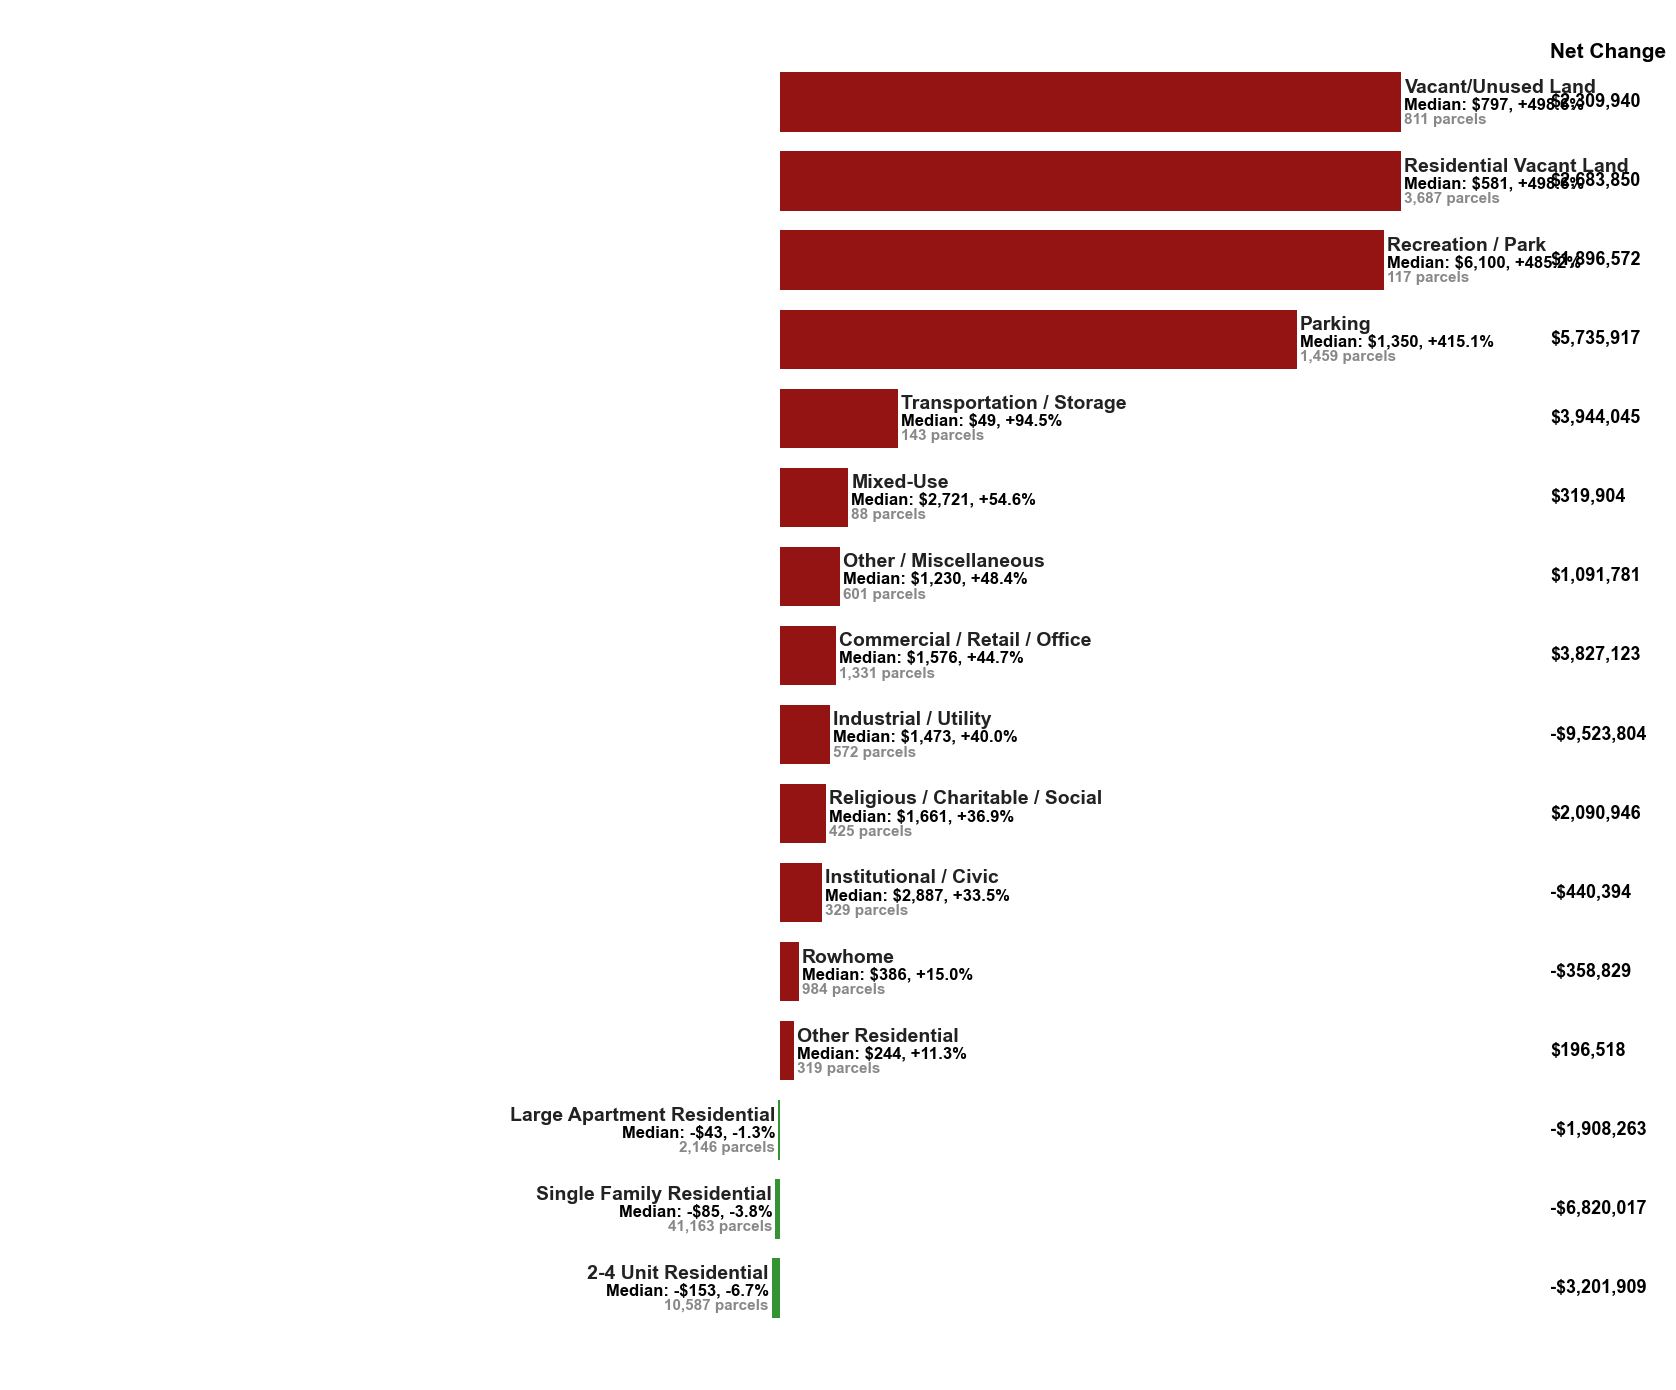

In [25]:
# Property category impact chart (Spokane style, sorted, ignore 0% median)
import matplotlib.pyplot as plt
import numpy as np

# Filter out categories where median tax change percent is exactly 0
filtered = category_summary[category_summary['median_tax_change_pct'] != 0].copy()

# Only include categories with property_count > 0 (optional, but safe)
filtered = filtered[filtered['property_count'] > 0]

# Sort by median_pct_change ascending (like Spokane)
categories = filtered['PROPERTY_CATEGORY'].tolist()
counts = filtered['property_count'].tolist()
median_pct_change = filtered['median_tax_change_pct'].tolist()
median_dollar_change = filtered['median_tax_change'].tolist()
total_tax_change = (
    filtered['total_tax_change_dollars'].tolist()
    if 'total_tax_change_dollars' in filtered.columns
    else (filtered['mean_tax_change'] * filtered['property_count']).tolist()
)

# Sort by median_pct_change ascending
sorted_idx = np.argsort(median_pct_change)
categories = [categories[i] for i in sorted_idx]
counts = [counts[i] for i in sorted_idx]
median_pct_change = [median_pct_change[i] for i in sorted_idx]
median_dollar_change = [median_dollar_change[i] for i in sorted_idx]
total_tax_change = [total_tax_change[i] for i in sorted_idx]

# Custom color: anything above 0 is dark red, below 0 is green
bar_colors = []
for val in median_pct_change:
    if val > 0:
        bar_colors.append("#8B0000")  # dark red
    else:
        bar_colors.append("#228B22")  # professional green

# Bar settings
bar_height = 0.75
fig_height = len(categories) * 0.8 + 1.2
right_col_pad = 120  # more padding for right column
fig, ax = plt.subplots(figsize=(17, fig_height))  # wider for right column

y = np.arange(len(categories))

# Draw bars
ax.barh(
    y, median_pct_change, color=bar_colors, edgecolor='none',
    height=bar_height, alpha=0.92, linewidth=0, zorder=2
)

# Remove all spines and ticks for a clean look
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Adjusted vertical spacing
cat_offset = 0.18   # less space between category and median
med_offset = -0.03  # median just below category
count_offset = -0.23  # more space below median for parcels

# For right column: position for total tax change
max_abs = max(abs(min(median_pct_change)), abs(max(median_pct_change)))
right_col_x = max_abs + right_col_pad

# Add Net Change header at the top of the right column
ax.text(
    right_col_x, len(categories) - 0.5, "Net Change", va='bottom', ha='left',
    fontsize=15, fontweight='bold', color='black', fontname='Arial'
)

for i, (cat, val, count, med_dol, tot_change) in enumerate(zip(categories, median_pct_change, counts, median_dollar_change, total_tax_change)):
    # Format median dollar and percent change together
    if med_dol >= 0:
        med_dol_str = f"${med_dol:,.0f}"
    else:
        med_dol_str = f"-${abs(med_dol):,.0f}"
    pct_str = f"{val:+.1f}%"
    median_combo = f"Median: {med_dol_str}, {pct_str}"

    # Position: right of bar for positive, left for negative
    if val < 0:
        xpos = val - 2.5
        ha = 'right'
    else:
        xpos = val + 2.5
        ha = 'left'
    # Category name (bold, bigger)
    ax.text(
        xpos, y[i]+cat_offset, cat, va='center', ha=ha,
        fontsize=14, fontweight='bold', color='#222',
        fontname='Arial'
    )
    # Median (dollar + percent, bold, black, just below category)
    ax.text(
        xpos, y[i]+med_offset, median_combo, va='center', ha=ha,
        fontsize=12, fontweight='bold', color='black',
        fontname='Arial'
    )
    # Count (bold, smaller, below median)
    ax.text(
        xpos, y[i]+count_offset, f"{count:,} parcels", va='center', ha=ha,
        fontsize=11, fontweight='bold', color='#888',
        fontname='Arial'
    )
    # Net change column, always right-aligned in a new column, black text, no "Total:"
    if tot_change >= 0:
        tot_change_str = f"${tot_change:,.0f}"
    else:
        tot_change_str = f"-${abs(tot_change):,.0f}"
    ax.text(
        right_col_x, y[i], tot_change_str, va='center', ha='left',
        fontsize=13, fontweight='bold', color='black',
        fontname='Arial'
    )

# Set x limits for symmetry, make bars longer, and leave space for right column
ax.set_xlim(-right_col_x, right_col_x + 60)

# Remove axis labels/ticks
ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()
plt.show()


In [27]:
# Output the count of CLASSDSCRP for PROPERTY_CATEGORY 'Other / Miscellaneous'
other_misc_mask = gdf['PROPERTY_CATEGORY'] == 'Other / Miscellaneous'
other_misc_class_counts = gdf.loc[other_misc_mask, 'CLASSDSCRP'].value_counts()
print("CLASSDSCRP counts for PROPERTY_CATEGORY = 'Other / Miscellaneous':")
print(other_misc_class_counts)

CLASSDSCRP counts for PROPERTY_CATEGORY = 'Other / Miscellaneous':
CLASSDSCRP
Other Storage                      484
Urban Renewal                       31
Other Educational Facility          12
Telephone                            6
Military                             3
Self Carwash                         2
Greenhouse                           2
Connectors                           2
Television                           2
Underwater                           1
Radio                                1
Cable TV                             1
Non-Cable TV                         1
Flood Control                        1
State Owned Land                     1
Gas Distribution, Outside Plant      1
Name: count, dtype: int64


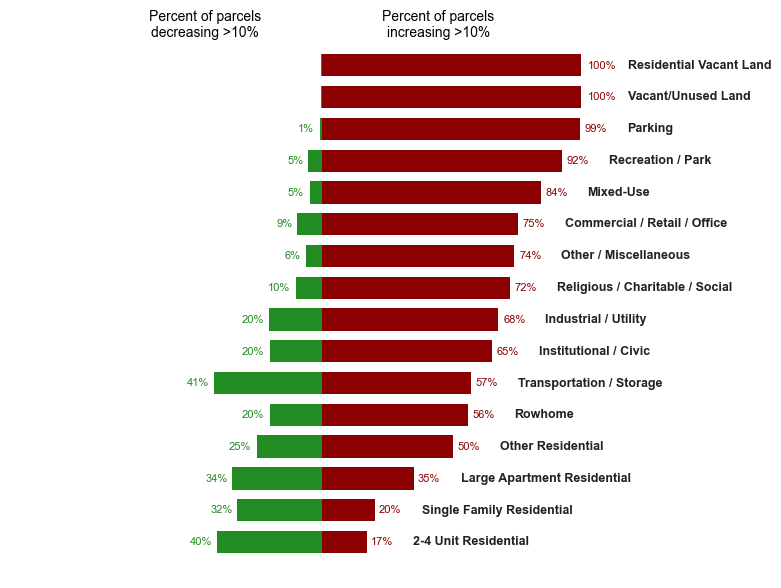

In [28]:
import matplotlib.pyplot as plt
import numpy as np
output_summary = category_summary
# Summarize output by PROPERTY_CATEGORY, using the output_summary DataFrame (as in Spokane)
summary_filtered = output_summary[output_summary['property_count'] > 50].copy()
summary_sorted = summary_filtered.sort_values('pct_increase_gt_threshold', ascending=True)

categories_sorted = summary_sorted['PROPERTY_CATEGORY'].tolist()
pct_increase_sorted = summary_sorted['pct_increase_gt_threshold'].tolist()
pct_decrease_sorted = summary_sorted['pct_decrease_gt_threshold'].tolist()

# Convert to integers for display
pct_increase_int_sorted = [int(round(x)) for x in pct_increase_sorted]
pct_decrease_int_sorted = [int(round(x)) for x in pct_decrease_sorted]

y = np.arange(len(categories_sorted))

fig, ax = plt.subplots(figsize=(8, 6))

color_increase = "#8B0000"
color_decrease = "#228B22"

# Plot decreases (green, left)
ax.barh(
    y, 
    [-v for v in pct_decrease_sorted], 
    color=color_decrease, 
    edgecolor='none', 
    height=0.7
)
# Plot increases (red, right)
ax.barh(
    y, 
    pct_increase_sorted, 
    color=color_increase, 
    edgecolor='none', 
    height=0.7
)

# Add percent labels
for i, (inc, dec) in enumerate(zip(pct_increase_int_sorted, pct_decrease_int_sorted)):
    if dec > 0:
        ax.text(
            -dec - 2, y[i], f"{dec}%", 
            va='center', ha='right', 
            fontsize=8, fontweight='normal', color=color_decrease, fontname='Arial'
        )
    if inc > 0:
        ax.text(
            inc + 2, y[i], f"{inc}%", 
            va='center', ha='left', 
            fontsize=8, fontweight='normal', color=color_increase, fontname='Arial'
        )

# Add category label, right of increase bar
for i, (cat, inc) in enumerate(zip(categories_sorted, pct_increase_sorted)):
    xpos = inc + 18 if inc > 0 else 18
    ax.text(
        xpos, y[i], cat, 
        va='center', ha='left', 
        fontsize=9, fontweight='bold', color='#222', fontname='Arial'
    )

# Minimalist: remove all spines, ticks, axis lines
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

# Symmetrize
max_val = max(max(pct_increase_sorted), max(pct_decrease_sorted))
ax.set_xlim(-max_val-20, max_val+48)

# Custom titles
title_fontsize = 10
title_color = 'black'
title_fontweight = 'normal'
title_fontname = 'Arial'
title_y = len(categories_sorted) - 0.2

left_title_x = -max_val * 0.45
ax.text(
    left_title_x, title_y, 
    "Percent of parcels\ndecreasing >10%", 
    ha='center', va='bottom', fontsize=title_fontsize, fontweight=title_fontweight, 
    color=title_color, fontname=title_fontname, 
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15')
)
right_title_x = max_val * 0.45
ax.text(
    right_title_x, title_y, 
    "Percent of parcels\nincreasing >10%", 
    ha='center', va='bottom', fontsize=title_fontsize, fontweight=title_fontweight, 
    color=title_color, fontname=title_fontname, 
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15')
)

plt.tight_layout()
plt.show()


# census

In [29]:
# Get census data for Monroe County, NY (Rochester) - FIPS code: 36055
print("📊 Loading Census data for Monroe County, NY...")
df  = gdf
try:
    census_data, census_boundaries = get_census_data_with_boundaries(
        fips_code="36055",  # Monroe County, NY
        year=2022
    )
    print("GOT CENSUS DATA")
    # Set CRS for census boundaries before merging
    census_boundaries = census_boundaries.set_crs(epsg=4326)  # Assuming WGS84 coordinate system

    # Ensure our parcel data is in the same CRS
    if df.crs != census_boundaries.crs:
        df = df.to_crs(census_boundaries.crs)

    # Merge census data with our parcel boundaries
    df = match_to_census_blockgroups(
        gdf=df,
        census_gdf=census_boundaries
    )

    print(f"✅ Census data integration complete!")
    print(f"Number of census block groups: {len(census_boundaries)}")
    print(f"Number of census data records: {len(census_data)}")
    print(f"Number of parcels with census data: {len(df)}")

    # Display new columns added
    census_cols = [col for col in df.columns if col in ['median_income', 'minority_pct', 'black_pct', 'total_pop', 'census_block_group']]
    print(f"Census columns added: {census_cols}")

except Exception as e:
    print(f"❌ Error loading census data: {e}")


📊 Loading Census data for Monroe County, NY...
GOT CENSUS DATA
✅ Census data integration complete!
Number of census block groups: 10063
Number of census data records: 597
Number of parcels with census data: 64762
Census columns added: ['median_income', 'total_pop', 'census_block_group', 'minority_pct', 'black_pct']


📊 Analyzing tax impacts by neighborhood income quintiles (Residential parcels only)...
✅ Income quintile analysis complete (Residential only)
Residential parcels with income data: 52,600 (90.8% of residential)


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_39094/3373369844.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_summary = df_with_income.groupby('income_quintile').agg({


,income_quintile,tax_change_count,tax_change_mean,tax_change_median,tax_change_pct_mean,tax_change_pct_median,median_income_mean,current_tax_mean
0,Q1 (Lowest),10583,1.67,63.96,67.19,4.55,23329.42,2091.63
1,Q2,11162,65.60,70.68,51.54,3.91,35584.81,2351.29
2,Q3,9968,-166.86,-94.68,18.70,-3.74,46094.96,3475.39
3,Q4,10468,-193.72,-182.66,14.68,-6.55,60104.23,3549.05
4,Q5 (Highest),10419,-547.09,-492.73,3.09,-12.50,90992.43,4783.88


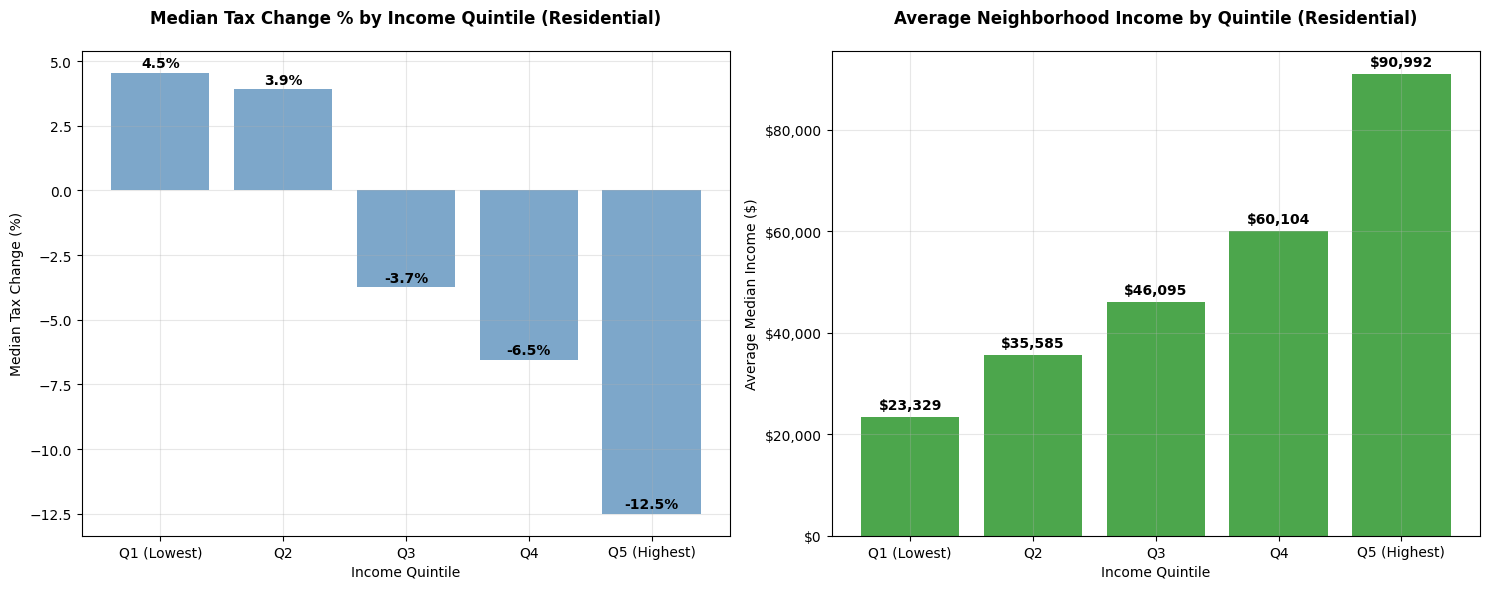

In [30]:
# Analyze tax impacts by income quintiles (similar to Spokane analysis), residential property only
print("📊 Analyzing tax impacts by neighborhood income quintiles (Residential parcels only)...")

if 'median_income' in df.columns:
    # Filter to only rows where property_category contains 'residential' (case-insensitive)
    df_residential = df[
        df['PROPERTY_CATEGORY'].str.contains('residential', case=False, na=False)
    ].copy()
    
    # Filter out parcels with missing or non-positive income data
    df_with_income = df_residential[(df_residential['median_income'].notna()) & (df_residential['median_income'] > 0)].copy()
    
    # Create income quintiles
    df_with_income['income_quintile'] = pd.qcut(
        df_with_income['median_income'], 
        5, 
        labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"]
    )
    
    # Calculate summary statistics by quintile
    quintile_summary = df_with_income.groupby('income_quintile').agg({
        'tax_change': ['count', 'mean', 'median'],
        'tax_change_pct': ['mean', 'median'],
        'median_income': 'mean',
        'current_tax': 'mean'
    }).round(2)
    
    # Flatten column names
    quintile_summary.columns = ['_'.join(col).strip() for col in quintile_summary.columns]
    quintile_summary = quintile_summary.reset_index()
    
    print(f"✅ Income quintile analysis complete (Residential only)")
    print(f"Residential parcels with income data: {len(df_with_income):,} ({len(df_with_income)/len(df_residential)*100:.1f}% of residential)")
    
    display(quintile_summary)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Median tax change percentage by income quintile
    quintile_data = quintile_summary.copy()
    quintile_data['median_tax_change_pct'] = quintile_data['tax_change_pct_median']
    
    bars1 = ax1.bar(
        quintile_data['income_quintile'],
        quintile_data['median_tax_change_pct'],
        color='steelblue',
        alpha=0.7
    )
    
    ax1.set_title('Median Tax Change % by Income Quintile (Residential)', fontweight='bold', pad=20)
    ax1.set_ylabel('Median Tax Change (%)')
    ax1.set_xlabel('Income Quintile')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars1, quintile_data['median_tax_change_pct']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Average neighborhood income by quintile
    bars2 = ax2.bar(
        quintile_data['income_quintile'],
        quintile_data['median_income_mean'],
        color='green',
        alpha=0.7
    )
    
    ax2.set_title('Average Neighborhood Income by Quintile (Residential)', fontweight='bold', pad=20)
    ax2.set_ylabel('Average Median Income ($)')
    ax2.set_xlabel('Income Quintile')
    ax2.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add value labels on bars
    for bar, val in zip(bars2, quintile_data['median_income_mean']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                f'${val:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Census income data not available - skipping quintile analysis")


In [35]:

# --- Export rochester.parquet with same columns as Syracuse ---
import os
import numpy as np

# Ensure df is a GeoDataFrame with correct CRS and columns
export_gdf = df.copy()

# Create full_exmp flag if taxable_value is < 1
export_gdf['full_exmp'] = export_gdf['taxable_value'] < 1


# 1. Exemption flag (1 if property is fully exempt, 0 otherwise)
# The Rochester data field is 'full_exmp' (boolean flag as used previously)
export_gdf['exemption_flag'] = (export_gdf['full_exmp'] == True).astype(int)

# 2. Property category
# Use existing field for main property category
export_gdf['property_land_use_category'] = export_gdf['PROPERTY_CATEGORY']

# 3. Refined property/land use category (Vacant, Parking Lot, Underdeveloped)
def categorize_property_refined_rochester(row):
    cat = str(row['PROPERTY_CATEGORY']).lower()
    if "vacant" in cat:
        return "Vacant"
    elif "parking" in cat:
        return "Parking Lot"
    # Underdeveloped: improvement < half (land + improvement) AND non-vacant/parking
    try:
        land_val = float(row['land_value']) if not pd.isnull(row['land_value']) else 0
        imp_val = float(row['improvement_value']) if not pd.isnull(row['improvement_value']) else 0
        # Only flag as underdeveloped if it's not already in above categories
        if imp_val < 0.5 * (land_val + imp_val) and imp_val > 0 and land_val > 100:  # avoid flagging if both zero
            return "Underdeveloped"
    except Exception:
        pass
    return None

export_gdf['property_land_use_refined'] = export_gdf.apply(categorize_property_refined_rochester, axis=1)

# 4. Area (in square feet) from geometry
# Prefer shape area if available and units are square feet, otherwise compute from geometry
if 'Shape__Area' in export_gdf.columns:
    # Double-check units, but often ESRI Shape__Area is in sq feet for New York exports, else fallback
    # We'll check against geometry (since geometry is projected to WGS84, area may be off) so use Shape__Area if plausible
    if export_gdf['Shape__Area'].max() > 100000:  # crude check: if numbers look like sq feet not sq meters
        export_gdf['area_sqft'] = export_gdf['Shape__Area']
    else:
        export_gdf['area_sqft'] = export_gdf['Shape__Area'] * 10.7639  # assume they're meters, convert to sq ft
else:
    # Compute from geometry (will be approximate with WGS84, but best fallback)
    # Sometimes the geometry is still in a projected system; if not, force to EPSG:2263 (NYS Plane) for area.
    if hasattr(export_gdf, "crs") and export_gdf.crs is not None and export_gdf.crs.to_epsg() != 2263:
        try:
            export_gdf = export_gdf.to_crs(2263)
        except Exception:
            pass  # fallback: stay in original CRS
    export_gdf['area_sqft'] = export_gdf.geometry.area

# 5. Current tax per square foot
export_gdf['current_tax_per_sqft'] = np.where(
    export_gdf['area_sqft'] > 0,
    export_gdf['current_tax'] / export_gdf['area_sqft'],
    0
)

# 6. Land value per square foot
export_gdf['land_value_per_sqft'] = np.where(
    export_gdf['area_sqft'] > 0,
    export_gdf['land_value'] / export_gdf['area_sqft'],
    0
)

# 7. Improvement value per square foot
export_gdf['improvement_value_per_sqft'] = np.where(
    export_gdf['area_sqft'] > 0,
    export_gdf['improvement_value'] / export_gdf['area_sqft'],
    0
)

# 8. Rename columns for export as required by Syracuse format
columns_to_export = [
    'geometry',
    'exemption_flag',
    'property_land_use_category',
    'property_land_use_refined',
    'current_tax',
    'current_tax_per_sqft',
    'land_value',
    'land_value_per_sqft',
    'improvement_value',
    'improvement_value_per_sqft'
]

rename_dict = {
    'land_value': 'current_full_land_value'
}

export_final = export_gdf[columns_to_export].rename(columns=rename_dict)

# Ensure geometry validity before reprojecting to WGS84/EPSG:4326
export_final['geometry'] = export_final['geometry'].apply(
    lambda g: g if g is None or g.is_valid else g.buffer(0)
)

# Force output CRS to WGS84 (EPSG:4326)
if not hasattr(export_final, "crs") or export_final.crs is None or export_final.crs.to_epsg() != 4326:
    try:
        export_final = export_final.set_geometry("geometry")
    except Exception:
        pass
    try:
        export_final = export_final.to_crs(epsg=4326)
        print("Converted to EPSG:4326")
    except Exception as e:
        print("Warning: Could not reproject to EPSG:4326:", str(e))

# Save as Parquet to Downloads
output_filename = os.path.expanduser("~/Downloads/rochester.parquet")
export_final.to_parquet(output_filename, index=False)
print(f"\n✅ Saved rochester.parquet to Downloads")
print("Saved columns:", export_final.columns.tolist())
print("Property refined category counts:")
print(export_final['property_land_use_refined'].value_counts(dropna=False))
print("Property category counts:")
print(export_final['property_land_use_category'].value_counts().head(10))

print(f"\n👀 First 5 rows of exported data:")
display(export_final.head())


Converted to EPSG:4326

✅ Saved rochester.parquet to Downloads
Saved columns: ['geometry', 'exemption_flag', 'property_land_use_category', 'property_land_use_refined', 'current_tax', 'current_tax_per_sqft', 'current_full_land_value', 'land_value_per_sqft', 'improvement_value', 'improvement_value_per_sqft']
Property refined category counts:
property_land_use_refined
None              58455
Vacant             4498
Parking Lot        1459
Underdeveloped      350
Name: count, dtype: int64
Property category counts:
property_land_use_category
Single Family Residential       41163
2-4 Unit Residential            10587
Residential Vacant Land          3687
Large Apartment Residential      2146
Parking                          1459
Commercial / Retail / Office     1331
Rowhome                           984
Vacant/Unused Land                811
Other / Miscellaneous             601
Industrial / Utility              572
Name: count, dtype: int64

👀 First 5 rows of exported data:


,geometry,exemption_flag,property_land_use_category,property_land_use_refined,current_tax,current_tax_per_sqft,current_full_land_value,land_value_per_sqft,improvement_value,improvement_value_per_sqft
0,"POLYGON ((-77.62248 43.26748, -77.62252 43.267...",0,2-4 Unit Residential,Underdeveloped,3661.770,0.125653,172500.0,5.919321,13000.0,0.446094
1,"POLYGON ((-77.62214 43.26731, -77.62216 43.267...",0,Single Family Residential,None,12665.184,0.347657,185000.0,5.078212,456600.0,12.533577
2,"POLYGON ((-77.62184 43.26715, -77.62186 43.267...",0,Single Family Residential,None,9376.500,0.541644,88000.0,5.083415,387000.0,22.355473
3,"POLYGON ((-77.62162 43.26704, -77.62164 43.267...",0,Single Family Residential,None,6415.500,0.365552,90500.0,5.156639,234500.0,13.361679
4,"POLYGON ((-77.62375 43.26671, -77.62375 43.266...",0,Single Family Residential,None,5227.152,0.965527,22800.0,4.211473,242000.0,44.700726


In [33]:


print(f"\\n✅ Analysis complete! Review the visualizations above for detailed insights.")


\n✅ Analysis complete! Review the visualizations above for detailed insights.
